# Introduction

**This example will show the steps needed to build a 3D convolutional neural network (CNN) to predict the presence of viral pneumonia in computer tomography (CT) scans. 2D CNNs are commonly used to process RGB images (3 channels). A 3D CNN is simply the 3D equivalent: it takes as input a 3D volume or a sequence of 2D frames (e.g. slices in a CT scan), 3D CNNs are a powerful model for learning representations for volumetric data.**

In [1]:
import tensorflow as tf
import seaborn as sns
import matplotlib.pyplot as plt
import os
import numpy as np
import pandas as pd
from keras import layers
import zipfile
import keras
import nibabel as nib
from scipy import ndimage
from tqdm import tqdm
import random
from sklearn.metrics import (accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report)

%matplotlib inline

# Downloading the MosMedData: Chest CT Scans with COVID-19 Related Findings

**In this example, we use a subset of the MosMedData: Chest CT Scans with COVID-19 Related Findings. This dataset consists of lung CT scans with COVID-19 related findings, as well as without such findings.**

**We will be using the associated radiological findings of the CT scans as labels to build a classifier to predict presence of viral pneumonia. Hence, the task is a binary classification problem.**

# Download url of normal CT scans.

In [2]:

url = "https://github.com/hasibzunair/3D-image-classification-tutorial/releases/download/v0.2/CT-0.zip"
filename = os.path.join(os.getcwd(), "CT-0.zip")
keras.utils.get_file(filename, url)

'/kaggle/working/CT-0.zip'

# Download url of abnormal CT scans.


In [3]:
url = "https://github.com/hasibzunair/3D-image-classification-tutorial/releases/download/v0.2/CT-23.zip"
filename = os.path.join(os.getcwd(), "CT-23.zip")
keras.utils.get_file(filename, url)

'/kaggle/working/CT-23.zip'

# Make a directory to store the data.

In [4]:
# os.makedirs("MosMedData")

# # Unzip data in the newly created directory.
# with zipfile.ZipFile("CT-0.zip", "r") as z_fp:
#     z_fp.extractall("./MosMedData/")

# with zipfile.ZipFile("CT-23.zip", "r") as z_fp:
#     z_fp.extractall("./MosMedData/")

# Loading data and preprocessing

**The files are provided in Nifti format with the extension .nii. To read the scans, we use the nibabel package. You can install the package via pip install nibabel. CT scans store raw voxel intensity in Hounsfield units (HU). They range from -1024 to above 2000 in this dataset. Above 400 are bones with different radiointensity, so this is used as a higher bound. A threshold between -1000 and 400 is commonly used to normalize CT scans.**

### To process the data, we do the following:

**We first rotate the volumes by 90 degrees, so the orientation is fixed We scale the HU values to be between 0 and 1.We resize width, height and depth.Here we define several helper functions to process the data. These functions will be used when building training and validation datasets.**

# read and load volume

In [5]:
def read_nifti_file(filepath):
    scan=nib.load(filepath)
    scan=scan.get_fdata()
    return scan

# normalize the volume

In [6]:
def normalize(volume):
    min_=-1000
    max_=400
    volume[volume<min_]=min_
    volume[volume>max_]=max_
    volume=(volume-min_)/(max_-min_)
    volume=volume.astype("float32")
    return volume


    

# Resize across z-axis

In [7]:
def resize_volume(img):
    desired_depth=64
    desired_width=128
    desired_height=128
    current_depth=img.shape[-1]
    current_width=img.shape[0]
    current_height=img.shape[1]
    depth=current_depth/desired_depth
    width=current_width/desired_width
    height=current_height/desired_height
    depth_factor=1/depth
    width_factor=1/width
    height_factor=1/height
    img=ndimage.rotate(img,90,reshape=False)
    img=ndimage.zoom(img,(width_factor,height_factor,depth_factor),order=1)
    return img


# read & resize volume

In [8]:
def process_scan(path):
    volume=read_nifti_file(path)
    volume=normalize(volume)
    volume=resize_volume(volume)
    return volume

# Let's read the paths of the CT scans from the class directories.

### Folder "CT-0" consist of CT scans having normal lung tissue,
### no CT-signs of viral pneumonia.

In [9]:
normal_scan_paths = [os.path.join(os.getcwd(), "/kaggle/working/MosMedData/CT-0", x) for x in os.listdir("/kaggle/working/MosMedData/CT-0")]

### Folder "CT-23" consist of CT scans having several ground-glass opacifications,
### involvement of lung parenchyma.

In [10]:
abnormal_scan_paths = [os.path.join(os.getcwd(), "/kaggle/working/MosMedData/CT-23", x) for x in os.listdir("/kaggle/working/MosMedData/CT-23")]


In [11]:
print("#"*70)
print("CT scans with normal lung tissue: " + str(len(normal_scan_paths)))
print("#"*70)
print("CT scans with abnormal lung tissue: " + str(len(abnormal_scan_paths)))
print("#"*70)

######################################################################
CT scans with normal lung tissue: 100
######################################################################
CT scans with abnormal lung tissue: 100
######################################################################


# Build train and validation datasets

**Read the scans from the class directories and assign labels. Downsample the scans to have shape of 128x128x64. Rescale the raw HU values to the range 0 to 1. Lastly, split the dataset into train and validation subsets.**

In [12]:
# Each scan is resized across height, width, and depth and rescaled.
abnormal_scans=np.array([process_scan(path) for path in tqdm(abnormal_scan_paths,desc="Processing Abnormal Scans")])
normal_scans=np.array([process_scan(path) for path in tqdm(normal_scan_paths,desc="Processing Normal Scans")])

Processing Normal Scans: 100%|██████████| 100/100 [03:37<00:00,  2.17s/it]


# For the CT scans having presence of viral pneumonia
# assign 1, for the normal ones assign 0.


In [13]:
abnormal_labels=np.array([1 for _ in range(len(abnormal_scans))])
normal_labels=np.array([0 for _ in range(len(normal_scans))])

# Split data in the ratio 70-30 for training and validation.

In [14]:
x_train = np.concatenate((abnormal_scans[:70], normal_scans[:70]), axis=0)
y_train = np.concatenate((abnormal_labels[:70], normal_labels[:70]), axis=0)
x_val = np.concatenate((abnormal_scans[70:], normal_scans[70:]), axis=0)
y_val = np.concatenate((abnormal_labels[70:], normal_labels[70:]), axis=0)
print("<=>"*70)
print("Train Data Shape : ",x_train.shape)
print("<=>"*70)
print(f"Train Label Shape : {y_train.shape}")
print("<=>"*70)
print(f"Valid Data Shape : {x_val.shape}")
print("<=>"*70)
print(f"Valid Label Shape : {y_val.shape}")
print("<=>"*70)

<=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=>
Train Data Shape :  (140, 128, 128, 64)
<=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=>
Train Label Shape : (140,)
<=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=>
Valid Data Shape : (60, 128, 128, 64)
<=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=>
Valid Label Shape : (60,)
<=><=><=><=><=><=><=><=><

# Data augmentation

**The CT scans also augmented by rotating at random angles during training. Since the data is stored in rank-3 tensors of shape (samples, height, width, depth), we add a dimension of size 1 at axis 4 to be able to perform 3D convolutions on the data. The new shape is thus (samples, height, width, depth, 1). There are different kinds of preprocessing and augmentation techniques out there, this example shows a few simple ones to get started.**

# Rotate the volume by a few degrees

In [15]:
def rotate(volume):
    def scipy_rotate(volume):
        angles=[-20,-10,-5,5,10,20]
        angle=random.choice(angles)
        volume=ndimage.rotate(volume,angle,reshape=False)
        volume[volume<0]=0
        volume[volume>1]=1
        return volume
    augmented_volume=tf.numpy_function(scipy_rotate,[volume],tf.float32)
    return augmented_volume

# Process training data by rotating and adding a channel.

def train_preprocessing(volume,label):
    volume=rotate(volume)
    volume=tf.expand_dims(volume,axis=3)
    return volume,label

# Process validation data by only adding a channel

def validation_preprocessing(volume,label):
    volume=tf.expand_dims(volume,axis=3)
    return volume,label
    

**While defining the train and validation data loader, the training data is passed through and augmentation function which randomly rotates volume at different angles. Note that both training and validation data are already rescaled to have values between 0 and 1.**

In [16]:
train_loader = tf.data.Dataset.from_tensor_slices((x_train, y_train))
validation_loader = tf.data.Dataset.from_tensor_slices((x_val, y_val))
batch_size=2
train_dataset = (train_loader.shuffle(len(x_train)).map(train_preprocessing).batch(batch_size).prefetch(2))
validation_dataset=(validation_loader.shuffle(len(x_val)).map(validation_preprocessing).batch(batch_size).prefetch(2))

# visualize images from train data

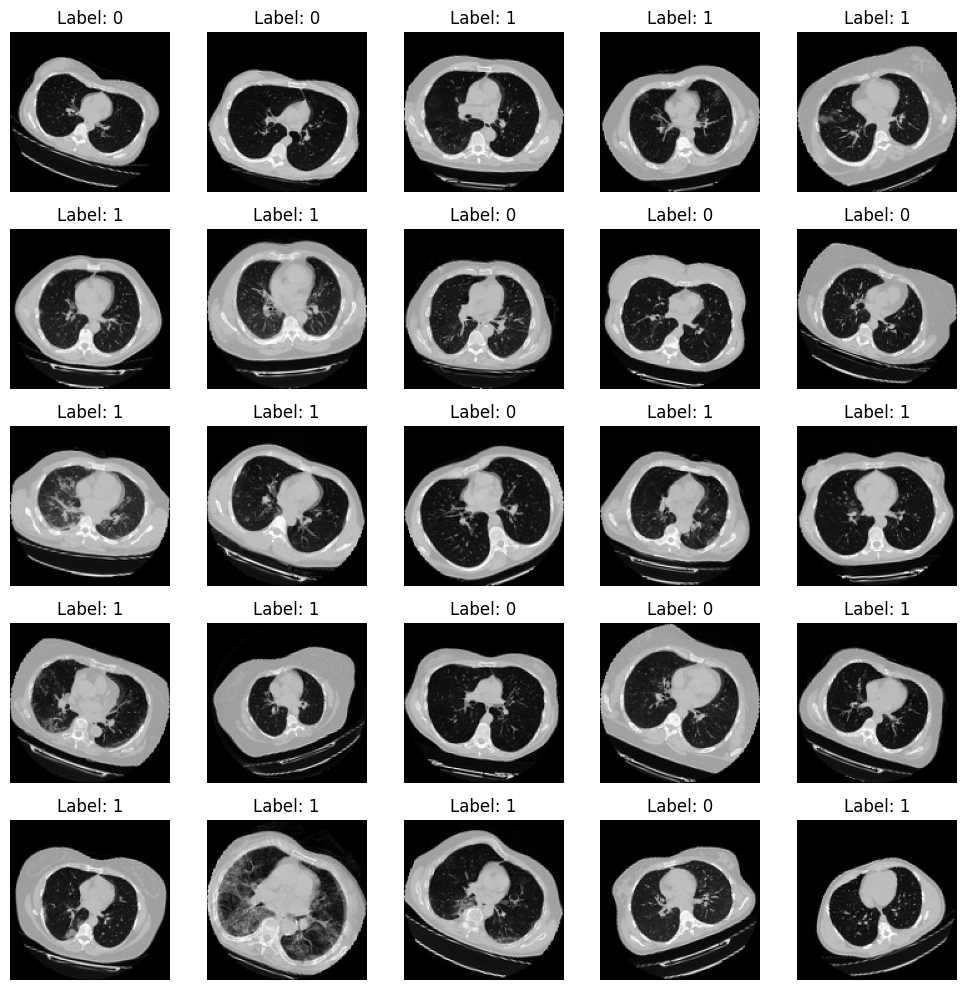

In [17]:

collected_images = []
collected_labels = []

for batch_images, batch_labels in train_dataset:
    batch_images, batch_labels = batch_images.numpy(), batch_labels.numpy()
    collected_images.extend(batch_images)
    collected_labels.extend(batch_labels)
    
    if len(collected_images) >= 25:
        break

collected_images = np.array(collected_images)
collected_labels = np.array(collected_labels)

random_indices = np.random.choice(len(collected_images), 25, replace=False)

fig, axes = plt.subplots(5, 5, figsize=(10, 10))
axes = axes.flatten()

for i, idx in enumerate(random_indices):
    ax = axes[i]
    img = collected_images[idx, :, :, 32]
    ax.imshow(img, cmap='gray')
    ax.set_title(f"Label: {collected_labels[idx]}")
    ax.axis('off')

plt.tight_layout()
plt.show()


# visualize images from validation dataset

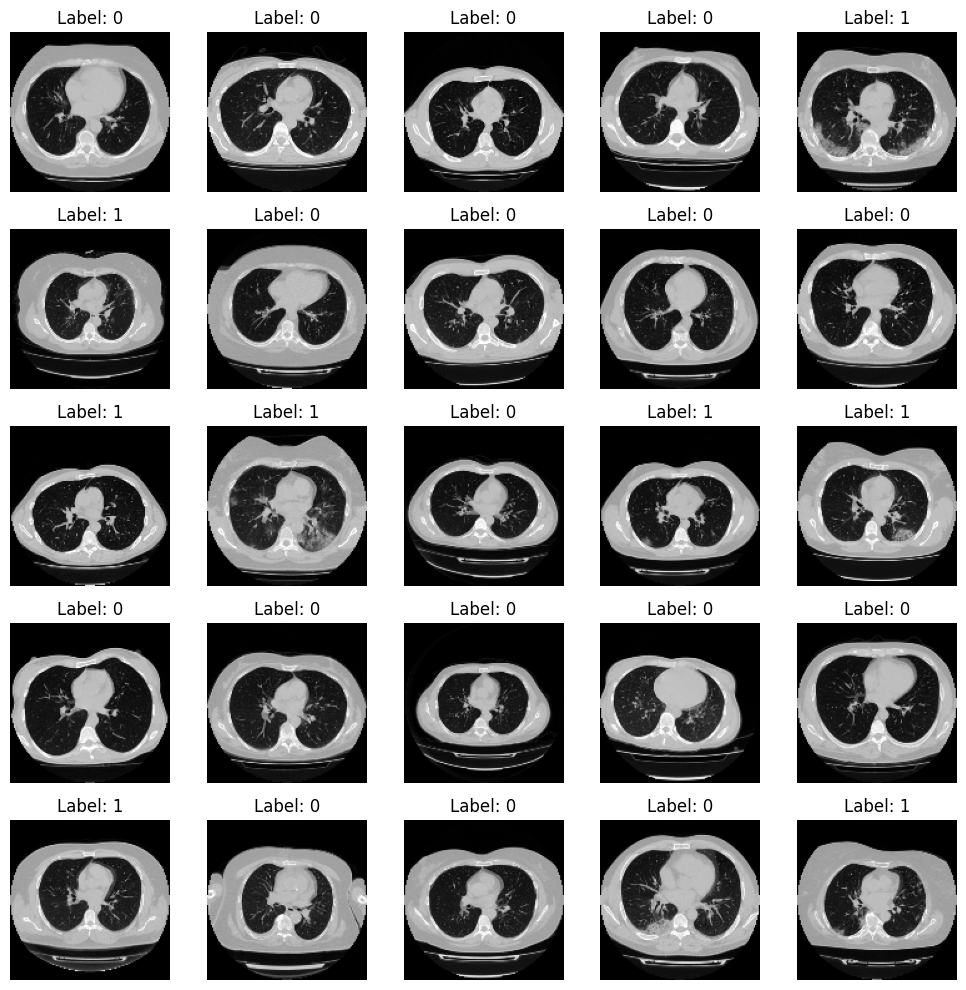

In [18]:

collected_images = []
collected_labels = []

for batch_images, batch_labels in validation_dataset:
    batch_images, batch_labels = batch_images.numpy(), batch_labels.numpy()
    collected_images.extend(batch_images)
    collected_labels.extend(batch_labels)
    
    if len(collected_images) >= 25:
        break

collected_images = np.array(collected_images)
collected_labels = np.array(collected_labels)

random_indices = np.random.choice(len(collected_images), 25, replace=False)

fig, axes = plt.subplots(5, 5, figsize=(10, 10))
axes = axes.flatten()

for i, idx in enumerate(random_indices):
    ax = axes[i]
    img = collected_images[idx, :, :, 32]
    ax.imshow(img, cmap='gray')
    ax.set_title(f"Label: {collected_labels[idx]}")
    ax.axis('off')

plt.tight_layout()
plt.show()


/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)


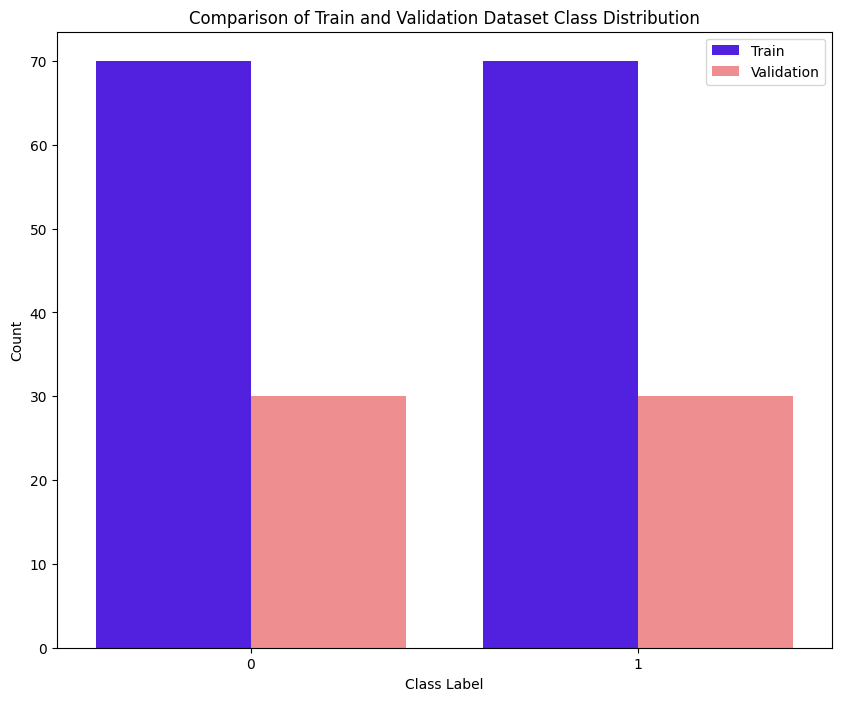

In [19]:


train_images, train_labels = [], []
val_images, val_labels = [], []

for batch_images, batch_labels in train_dataset:
    train_images.extend(batch_images.numpy())
    train_labels.extend(batch_labels.numpy())

for batch_images, batch_labels in validation_dataset:
    val_images.extend(batch_images.numpy())
    val_labels.extend(batch_labels.numpy())

train_labels = np.array(train_labels)
val_labels = np.array(val_labels)

train_class_counts = np.bincount(train_labels)
val_class_counts = np.bincount(val_labels)

data = {
    "Dataset": ["Train"] * len(train_class_counts) + ["Validation"] * len(val_class_counts),
    "Class": list(range(len(train_class_counts))) * 2,
    "Count": np.concatenate([train_class_counts, val_class_counts])
}

plt.figure(figsize=(10, 8))
sns.barplot(x="Class", y="Count", hue="Dataset", data=data,palette="gnuplot2")
plt.xlabel("Class Label")
plt.ylabel("Count")
plt.title("Comparison of Train and Validation Dataset Class Distribution")
plt.legend()
plt.show()


In [20]:
data

{'Dataset': ['Train', 'Train', 'Validation', 'Validation'],
 'Class': [0, 1, 0, 1],
 'Count': array([70, 70, 30, 30])}

# Define a 3D convolutional neural network

In [21]:
def get_model(width=128, height=128, depth=64):
   

    inputs = keras.Input((width, height, depth, 1))

    x = layers.Conv3D(filters=64, kernel_size=3, activation="relu")(inputs)
    x = layers.MaxPool3D(pool_size=2)(x)
    x = layers.BatchNormalization()(x)

    x = layers.Conv3D(filters=64, kernel_size=3, activation="relu")(x)
    x = layers.MaxPool3D(pool_size=2)(x)
    x = layers.BatchNormalization()(x)

    x = layers.Conv3D(filters=128, kernel_size=3, activation="relu")(x)
    x = layers.MaxPool3D(pool_size=2)(x)
    x = layers.BatchNormalization()(x)

    x = layers.Conv3D(filters=256, kernel_size=3, activation="relu")(x)
    x = layers.MaxPool3D(pool_size=2)(x)
    x = layers.BatchNormalization()(x)

    x = layers.GlobalAveragePooling3D()(x)
    x = layers.Dense(units=512, activation="relu")(x)
    x = layers.Dropout(0.3)(x)

    outputs = layers.Dense(units=1, activation="sigmoid")(x)

    # Define the model.
    model = keras.Model(inputs, outputs, name="3dcnn")
    return model


# Build model.
model = get_model(width=128, height=128, depth=64)
learning_rate=0.0001
lr_schedule=keras.optimizers.schedules.ExponentialDecay(learning_rate,decay_steps=100000,decay_rate=0.96,staircase=True)
model.compile(loss="binary_crossentropy",optimizer=keras.optimizers.Adam(learning_rate=lr_schedule),
              metrics=["accuracy"],run_eagerly=True)
early_stopping_cb = keras.callbacks.EarlyStopping(monitor="val_acc", patience=15)

model.summary()

Model: "3dcnn"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 128, 128, 64, 1)     │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv3d (Conv3D)                      │ (None, 126, 126, 62, 64)    │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling3d (MaxPooling3D)         │ (None, 63, 63, 31, 64)      │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 63, 63, 31, 64)      │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv3d_1 (Conv3D)                    │ (None, 61, 61, 29, 64)      │         110,656 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling3d_1 (MaxPooling3D)       │ (None, 30, 30, 14, 64)      │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 30, 30, 14, 64)      │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv3d_2 (Conv3D)                    │ (None, 28, 28, 12, 128)     │         221,312 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling3d_2 (MaxPooling3D)       │ (None, 14, 14, 6, 128)      │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 14, 14, 6, 128)      │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv3d_3 (Conv3D)                    │ (None, 12, 12, 4, 256)      │         884,992 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling3d_3 (MaxPooling3D)       │ (None, 6, 6, 2, 256)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 6, 6, 2, 256)        │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling3d             │ (None, 256)                 │               0 │
│ (GlobalAveragePooling3D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 512)                 │         131,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │             513 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,352,897 (5.16 MB)

 Trainable params: 1,351,873 (5.16 MB)

 Non-trainable params: 1,024 (4.00 KB)

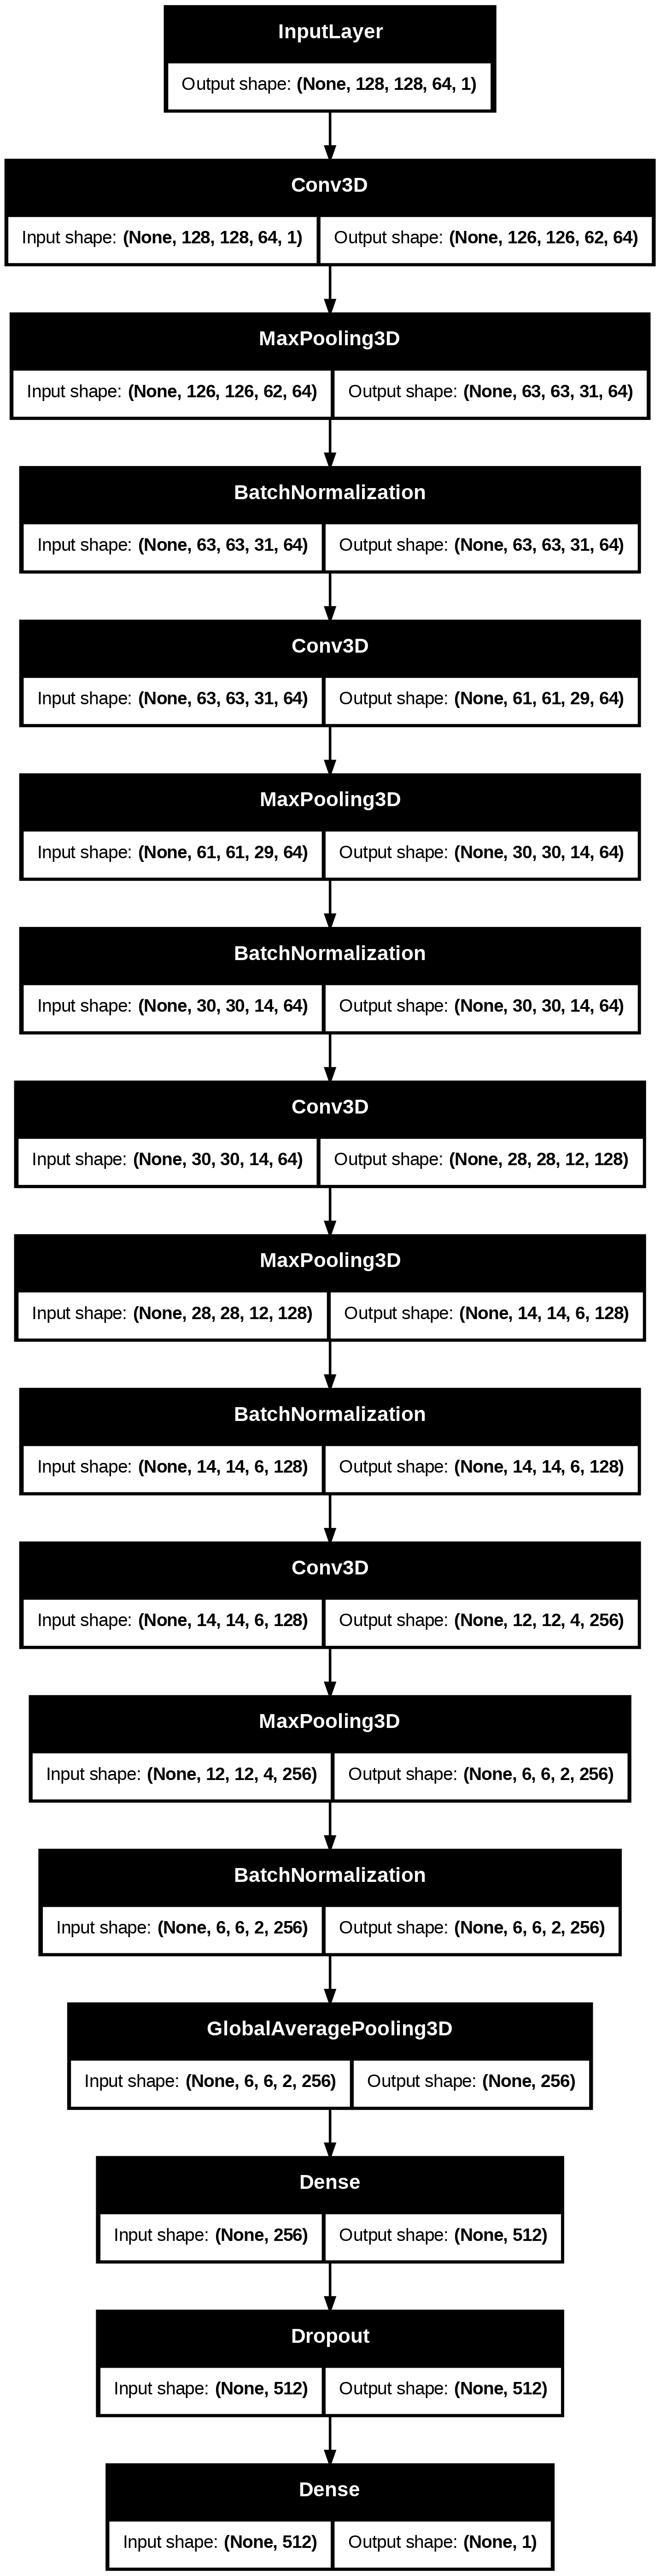

In [22]:
keras.utils.plot_model(model, show_shapes=True)

In [23]:
early_stopping_cb = keras.callbacks.EarlyStopping(monitor="val_accuracy", patience=15)
epochs = 50
history=model.fit(train_dataset,validation_data=validation_dataset,epochs=epochs,shuffle=True,verbose=1,callbacks=[early_stopping_cb])

Epoch 1/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 29s 355ms/step - accuracy: 0.6130 - loss: 0.6495 - val_accuracy: 0.5000 - val_loss: 1.1839
Epoch 2/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 26s 367ms/step - accuracy: 0.6424 - loss: 0.6329 - val_accuracy: 0.5000 - val_loss: 1.0978
Epoch 3/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 26s 367ms/step - accuracy: 0.6990 - loss: 0.6312 - val_accuracy: 0.5000 - val_loss: 0.7167
Epoch 4/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 26s 366ms/step - accuracy: 0.6641 - loss: 0.5825 - val_accuracy: 0.5000 - val_loss: 1.4183
Epoch 5/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 26s 365ms/step - accuracy: 0.7111 - loss: 0.6024 - val_accuracy: 0.5000 - val_loss: 1.3966
Epoch 6/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 26s 365ms/step - accuracy: 0.6891 - loss: 0.6482 - val_accuracy: 0.6167 - val_loss: 0.7074
Epoch 7/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 26s 368ms/step - accuracy: 0.6992 - loss: 0.6262 - val_accuracy: 0.5000 - val_loss: 0.9549
Epoch 8/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 26s 364ms/step - accuracy: 0.6506 - loss: 0.6054 - val_accu

# Visualizing model performance

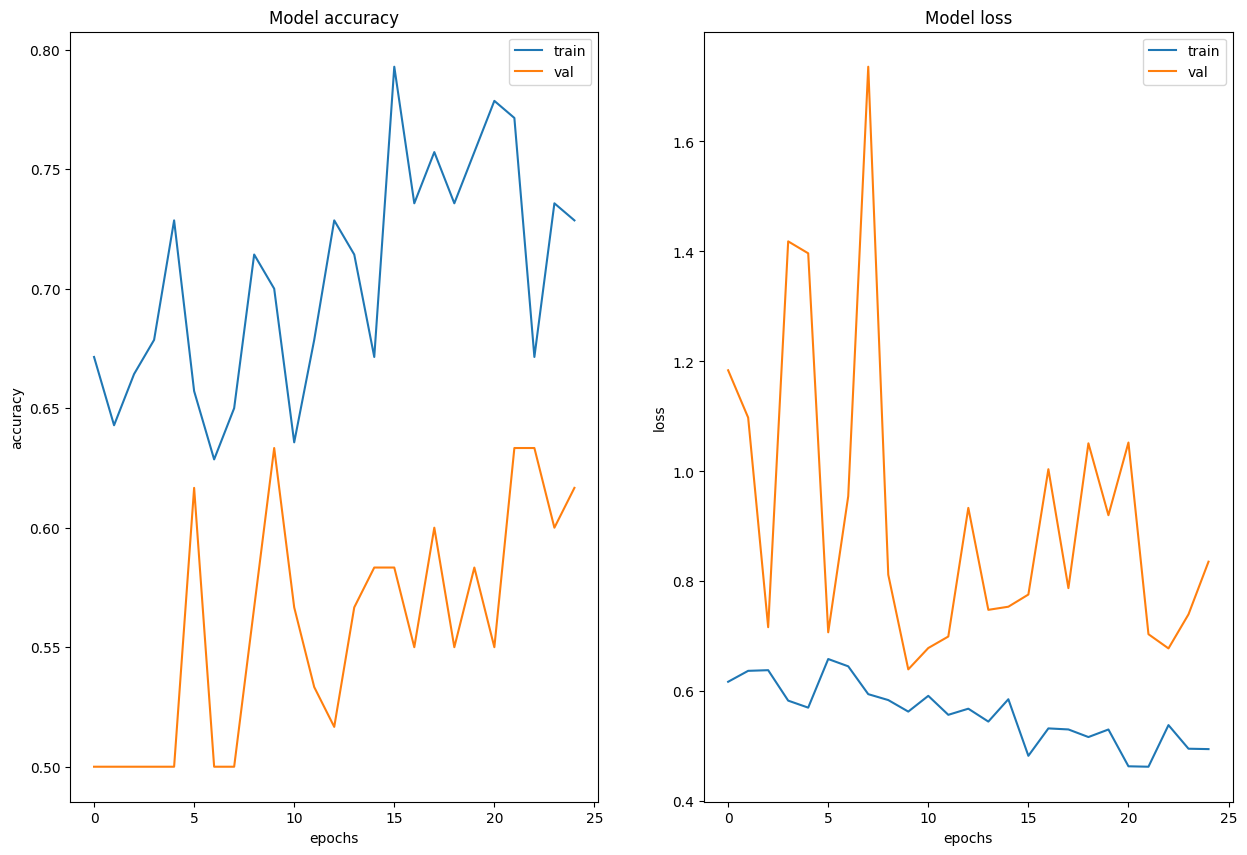

In [24]:
fig, ax = plt.subplots(1, 2, figsize=(15,10))
ax = ax.ravel()

for i, metric in enumerate(["accuracy", "loss"]):
    ax[i].plot(model.history.history[metric])
    ax[i].plot(model.history.history["val_" + metric])
    ax[i].set_title("Model {}".format(metric))
    ax[i].set_xlabel("epochs")
    ax[i].set_ylabel(metric)
    ax[i].legend(["train", "val"])
plt.show()

In [25]:
y_true = []
y_pred = []

for images, labels in validation_dataset:
    preds = model.predict(images)
    y_pred.extend(np.round(preds).flatten())  # Rounding probabilities to 0 or 1
    y_true.extend(labels.numpy().flatten())  # Flattening labels

y_true = np.array(y_true, dtype=int)
y_pred = np.array(y_pred, dtype=int)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━

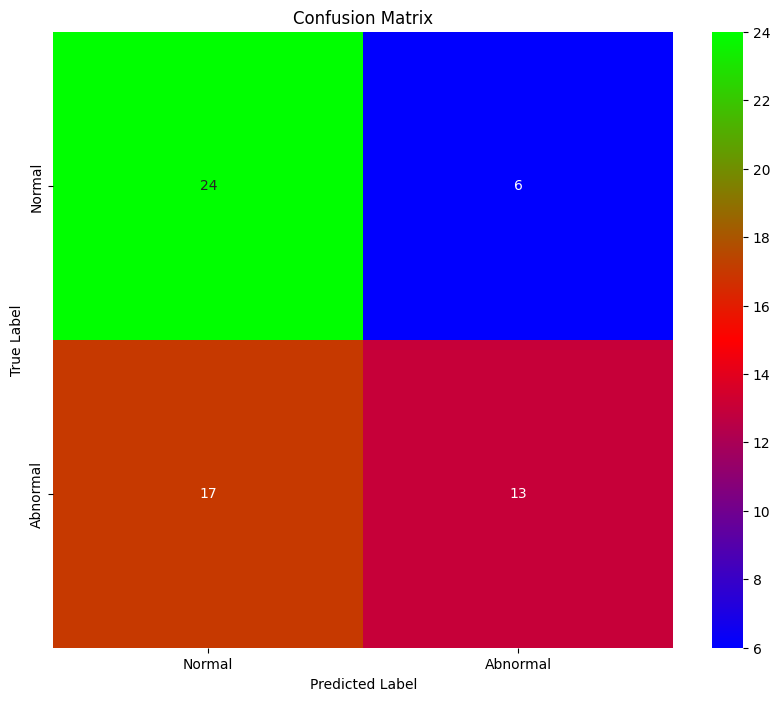

In [26]:
cm = confusion_matrix(y_true, y_pred)
label_name=["Normal","Abnormal"]
plt.figure(figsize=(10,8))
sns.heatmap(cm, annot=True, fmt='d', cmap='brg', xticklabels=label_name, yticklabels=label_name)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

In [27]:
accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred)
recall = recall_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred)
report = classification_report(y_true, y_pred, target_names=label_name)
print("#"*80)
print(f"Accuracy: {accuracy:.4f}")
print("#"*80)
print(f"Precision: {precision:.4f}")
print("#"*80)
print(f"Recall: {recall:.4f}")
print("#"*80)
print(f"F1 Score: {f1:.4f}")
print("#"*80)
print("\nClassification Report:\n", report)
print("#"*80)

################################################################################
Accuracy: 0.6167
################################################################################
Precision: 0.6842
################################################################################
Recall: 0.4333
################################################################################
F1 Score: 0.5306
################################################################################

Classification Report:
               precision    recall  f1-score   support

      Normal       0.59      0.80      0.68        30
    Abnormal       0.68      0.43      0.53        30

    accuracy                           0.62        60
   macro avg       0.63      0.62      0.60        60
weighted avg       0.63      0.62      0.60        60

################################################################################


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━

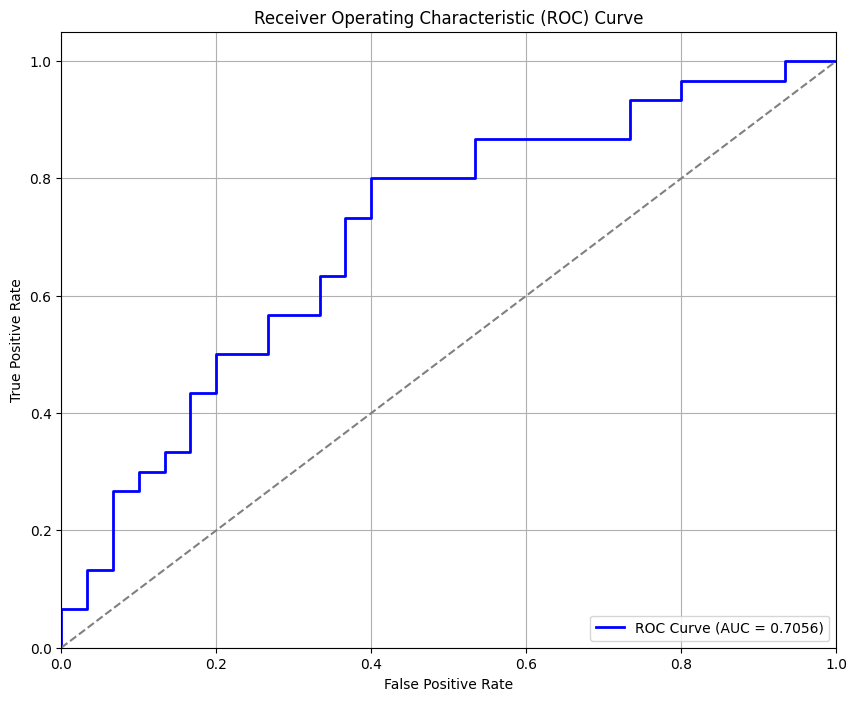

In [28]:
from sklearn.metrics import roc_curve, auc

y_true = []
y_scores = []

for images, labels in validation_dataset:
    preds = model.predict(images).flatten()  # Get predicted probabilities
    y_scores.extend(preds)
    y_true.extend(labels.numpy().flatten())  # Get true labels

y_true = np.array(y_true, dtype=int)
y_scores = np.array(y_scores)

# Compute ROC curve and AUC
fpr, tpr, _ = roc_curve(y_true, y_scores)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(10,8))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC Curve (AUC = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')  # Diagonal reference line
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.grid()
plt.show()

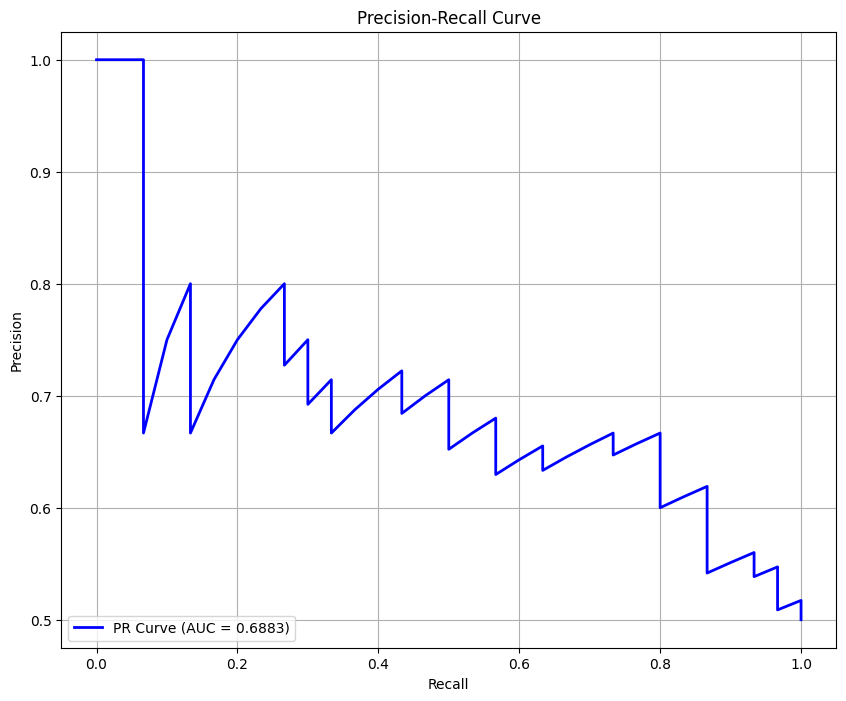

In [29]:
from sklearn.metrics import precision_recall_curve, auc
precision, recall, _ = precision_recall_curve(y_true, y_scores)
pr_auc = auc(recall, precision)  # Area under PR curve

# Plot Precision-Recall curve
plt.figure(figsize=(10,8))
plt.plot(recall, precision, color='blue', lw=2, label=f'PR Curve (AUC = {pr_auc:.4f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc="lower left")
plt.grid()
plt.show()

# Model Prediction

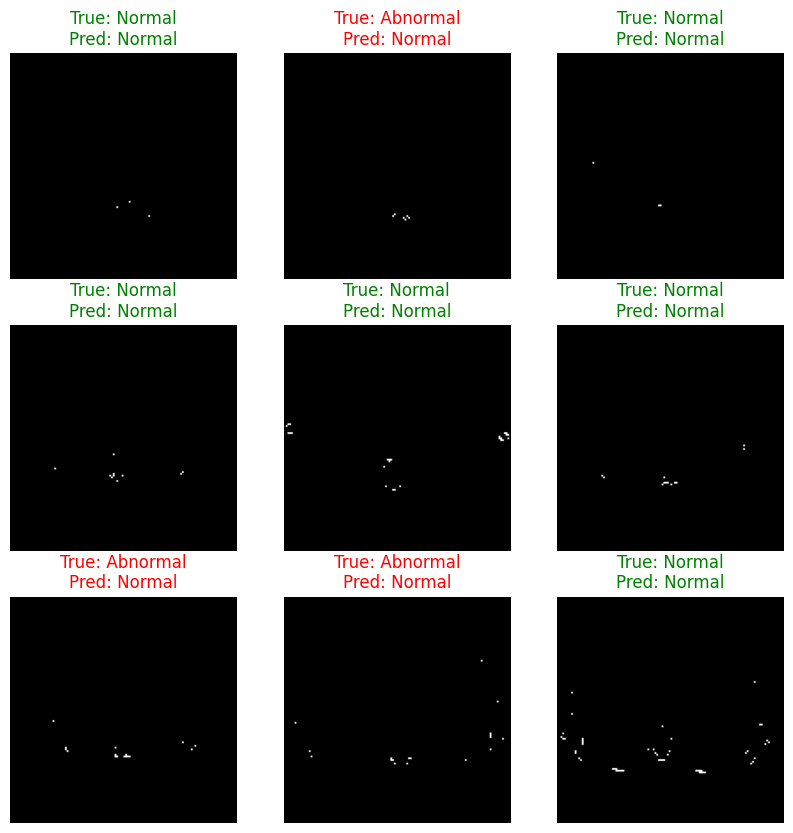

In [30]:


def predict_and_plot(model, test_data, label_names, num_images=9):
    images = []
    labels = []
    predicted_labels = []

    for image_batch, label_batch in test_data.take((num_images // 2) + 1):  # Process multiple batches
        predictions = model(image_batch)
        predicted_labels_batch = np.argmax(predictions.numpy(), axis=1)

        images.append(image_batch.numpy())
        labels.append(label_batch.numpy())
        predicted_labels.append(predicted_labels_batch)

        if len(images) * 2 >= num_images:
            break

    images = np.concatenate(images, axis=0)
    labels = np.concatenate(labels, axis=0)
    predicted_labels = np.concatenate(predicted_labels, axis=0)

    plt.figure(figsize=(10, 10))

    for i in range(num_images):
        ax = plt.subplot(3, 3, i + 1)
        img = images[i, :, :, 32].astype("uint8")
        plt.imshow(img, cmap='gray')
        true_label = label_names[labels[i]]
        pred_label = label_names[predicted_labels[i]]
        color = 'green' if labels[i] == predicted_labels[i] else 'red'
        ax.set_title(f"True: {true_label}\nPred: {pred_label}", color=color)
        plt.axis("off")

    plt.show()

predict_and_plot(model, validation_dataset, label_name, num_images=9)


# Make predictions on a single CT scan

In [31]:
prediction = model.predict(np.expand_dims(x_val[0], axis=0))[0]
scores = [1 - prediction[0], prediction[0]]

class_names = ["normal", "abnormal"]
for score, name in zip(scores, class_names):
    print(
        "This model is %.2f percent confident that CT scan is %s"
        % ((100 * score), name)
    )

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step
This model is 28.25 percent confident that CT scan is normal
This model is 71.75 percent confident that CT scan is abnormal
